# Conclusions
### [RN] 2/11/2021

I am pretty much done with my part of the project, Katherine will be handling the error analysis. I am going to summarize all my conclusions and wrap everything up to make my presentation tomorrow. 

## Basics 
Here are the differentials for the basic SIR, as given in the lab manual. 

$\frac{dS(t)}{dt} = -k\frac{S(t)}{N}I(t)$

$\frac{dI(t)}{dt} = k\frac{S(t)}{N}I(t)-gI(t)$

$\frac{dR}{dt} = gI(t)$

Here are the differentials for the extended model. 


$\frac{dS(t)}{dt} = -k\frac{S(t)}{N}I(t) - v(t)\left(\frac{S(t)}{R(t) + S(t)}\right) + \frac{1}{w}R(t)$


$\frac{dI(t)}{dt} = k\frac{S(t)}{N}I(t)-gI(t)$


$\frac{dR(t)}{dt} = gI(t)-D(t)-v(t)\left(\frac{R(t)}{R(t) + S(t)}\right) - \frac{1}{w}R(t)$
 

$\frac{dH(t)}{dt} = \begin{cases}
    H(t) + v(t)\left(R(t) + S(t)\right), & t > lag \\
    0, & t < lag
    \end{cases}$ 

$\frac{dD(t)}{dt} = dI(t)$ 

$v(t) = v\left(\frac{t}{r+x}\right)$

Here are the groups which the total population of N people are categorized in to model the epidemic. 

**Groups**

Susceptible population (S): This is the number of people that are susceptible to infection at a given time. 

Infected population (I): This is the number of people who are infected at a given time. 

Recovered population (R): Number of people that have recovered post infection, who cannot be infected again. In the basic SIR, once recovered from infection, an individual is permanently in the R group. In reality, people can get infected twice after a period of temporary immunity. In the extended model, people in the R group re-enter the S group after a period of temporary immunity has ended. 

Immune population (H): This is the group that represents "herd immunity". They are vaccinated and permanently immune. People in S and R groups have equal probability of being vaccinated to permanently enter this H group. 

Deceased (D): This is the number of deaths due to infection over time. Therefore these people are removed from R groups and not viable for vaccines to enter the H group, or re-enter the S group. 

For the basic SIR model, S + I + R = N must be true for all time. For the extended model, S + I + R + D + H = N for all time. This was systematically checked throuout the process by a function that returns false if this is not the case. 

**Parameters & Initial Conditions**
All units are in days

k: the number of people each infected person infects per day

g: 1/T, T being the number of days it takes each infected person to recover 

w: the number of days a person who has been infected has temporary immunity since infection. For example, if w=90, then 90 days after becoming infected they may become infected again. Thus after w days, a person in R re-enters S. 

d: percent of infected people who will pass away

A: percent of population that will never be vaccinated. e.g. anti-vaxxers or people who do not have access or who do not take well to the vaccine. They will permanently remain in S group. 

v: this is the number of people that will be vaccinated per day at maximum capacity. Assume that this is the value limited by manufacturing and adminstrative capacity

r: The number of days at which vaccination will occur at half the expected maximum capacity. This is to account for the fact that vaccinations are not adminstered at full capacity right away due to developing as we go. Thus the amount of vaccines given per day is determined by: 

$v(t) = v\left(\frac{t}{r+t}\right)$ 

Such that the rate of vaccination is tunable and more realistic. 

lag: the number of days after day 0 that it takes to develop the vaccine and adminster the first vaccine. This way the point in the epedimic at which the H population starts to build up is tunable. 

dt: This tells the function what time to increment at. The function workes iteratively using the fundamental theorem of calculus, so the time step does matter to some extent. I did some quick analysis on this that I will include later. The model works by the following assumptions: 

$\frac{dF(t)}{dt} = g(a, b, ...., t)$

$dF = g(a, b, ...., t)dt$

$F(t+dt) \approx F(t) + dF = F(t) + g(a, b, ...., t)dt$

duration: The number of days to run the model for.  

$N_0$: number of people initially infected. 

$S_0$: The number of people initially susceptible should be $N-I_0$



## Libraries I used 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.stats as stats

## Actual code 

In [1]:
### The actual functions

def SIRHD(I0, N, k, g, v, lag, r, A, d, w, dt, duration): # susceptible, infected, temporarily immune, dead, herd immune
    j = int(duration/dt)
    time_elapsed = 0 # go for duration, iterating by dt
    I, S, R, H, D = np.zeros(j), np.zeros(j), np.zeros(j), np.zeros(j), np.zeros(j) # i will iterate and fill these in with values 
    IPD = np.zeros(j) # infected per day
    R[0] = 0 # set initial values as given. 
    I[0] = I0
    S[0] = N-I0
    H[0] = 0 # starts with no people vaccinated
    D[0] = 0
    IPD[0] = 0
    for i in range(1, j): # increment SIR by dt. eg X(t+dt) = X(t) + dX. Log totals in the arrays. 
        dR = g*I[i-1]*dt - (1/w)*R[i-1] * dt # get dX values from equation 6
        dI = ((k/N)*S[i-1]*I[i-1]-g*I[i-1])*dt
        if i*dt > lag:  # introduce number of days into pandemic it takes to get vaccinations going 
            since_vacc = i*dt -lag
            vr = v*(since_vacc)*(1/(r+since_vacc)) # the amount of people vaccined per day is more of a logarithmic increase rather than linear  
            if (S[i-1] + R[i-1]) < v: # if there are no unvaccinated people
                S[i-1] = A*N # only anti vaxxers remain susceptible 
                H[i-1] = N - S[i-1] - I[i-1] - R[i-1]-D[i-1] # now everyone is vaccinated! 
                dS = 0 # these stay constant 
                dH = 0
            else:
                pool = S[i-1] + R[i-1]
                wS = S[i-1]/pool # weight R and S groups to remove vaccined group
                wR = R[i-1]/pool # R and S people have equal probability of being vaccinated 
                dH = vr*dt
                dS = -(k/N) * S[i-1]*I[i-1]*dt - vr*dt*wS + (1/w)*R[i-1]*dt
                dR = dR - vr*dt*wR
        else: 
            dS = -(k/N) * S[i-1]*I[i-1]*dt + (1/w)*R[i-1]*dt
            dH = 0
        dD = I[i-1]*d*dt # amount of dead people in this time step 
        dR = dR - dD # remove dead population from initially calculated recovered 
        I[i] = I[i-1]+dI  # add increment to last value X(t) to get X(t+dt)
        R[i] = R[i-1]+dR
        D[i] = D[i-1]+dD
        S[i] = S[i-1]+dS
        H[i] = H[i-1]+dH # linearly remove vaccined population, which is limited by number of vaccines given per day
    return S, I, R, H, D # return S, I, and R arrays indexed by time.

def CheckTotal(S, I, R, H, D, N): 
    nonN = 0
    for i in range(len(S)):
        total = S[i] + I[i] + R[i] + H[i] + D[i]
        if N-total > 0.001*N:
            nonN = nonN+1
            print(N - total, i)
    if nonN == 0:
        return True # SIR all add up to N at any given time
    else:
        return False # something went wrong. total is not N.

def SIR(I0, N, k, g, dt, duration):
    j = int(duration/dt)
    time_elapsed = 0 # go for duration, iterating by dt
    I, S, R = np.zeros(j), np.zeros(j), np.zeros(j) # i will iterate and fill these in with values 
    R[0] = g*I0 # set initial values as given. 
    I[0] = I0
    S[0] = N-1
    for i in range(1, j): # increment SIR by dt. eg X(t+dt) = X(t) + dX. Log totals in the arrays. 
        dR = g*I[i-1]*dt # get dX values from equation 6
        dI = ((k/N)*S[i-1]*I[i-1]-g*I[i-1])*dt
        dS = -(k/N) * S[i-1]*I[i-1]*dt
        I[i] = I[i-1]+dI  # add increment to last value X(t) to get X(t+dt)
        R[i] = R[i-1]+dR
        S[i] = S[i-1]+dS
    return S, I, R   # return S, I, and R arrays indexed by time.

## Useful things in my notebooks

### 20210131_FirstLooks

- making basic model 

### 20210202_TuesdayMeeting

- extracted real data into useful arrays from [this](https://github.com/rnnisi/covid19_scenarios) data set
- extracting k from real data by binning data and picking regions that fit relatively well to a line 

### 20210205_FridayMeeting

- verified that my method for solving the differentials iteratively works using a well understood differential equation 
- study of how the timestep (dt) affects solution 

### 20210209_TuesdayMeeting

- worked on developing extension 

### 2021021_FinishingSIRHD

- finalized extension 
- tried using binning method to algorithmically find best fit for k. This gave k on order of magnitute $10^{-3}$ which made $R_0 = \frac{k}{g}$ << 1, which broke the SIR model
- tried to find k using just the initial and final infected population numbers so that I could get something that would atleast project from where we are at now. This also broke the model
- did some plotting and digging to see that the real covid growth is not really appropriate to model with the base function we were given 
- used ISS (initial steady state) analysis to determine that the first 12 days were the most days I could fit to find a k value using chi-squares of corresponding exponential growth functions to real data. k = 0.015. 
- made a figure that compares the basic SIR model and the extended SIR models with and without vaccination introduced 
--> for these figures: v = N * 0.001, lag = 100, r = 50, w = 90, A = 0.01, k = 0.15 (from data), I0 = 53 (from data), g = 1/14 (used in lab notebook), dt = 0.01, N = $39.5*10^{6} (actual population of CA), w = 90, d = 0.016 (average from data)

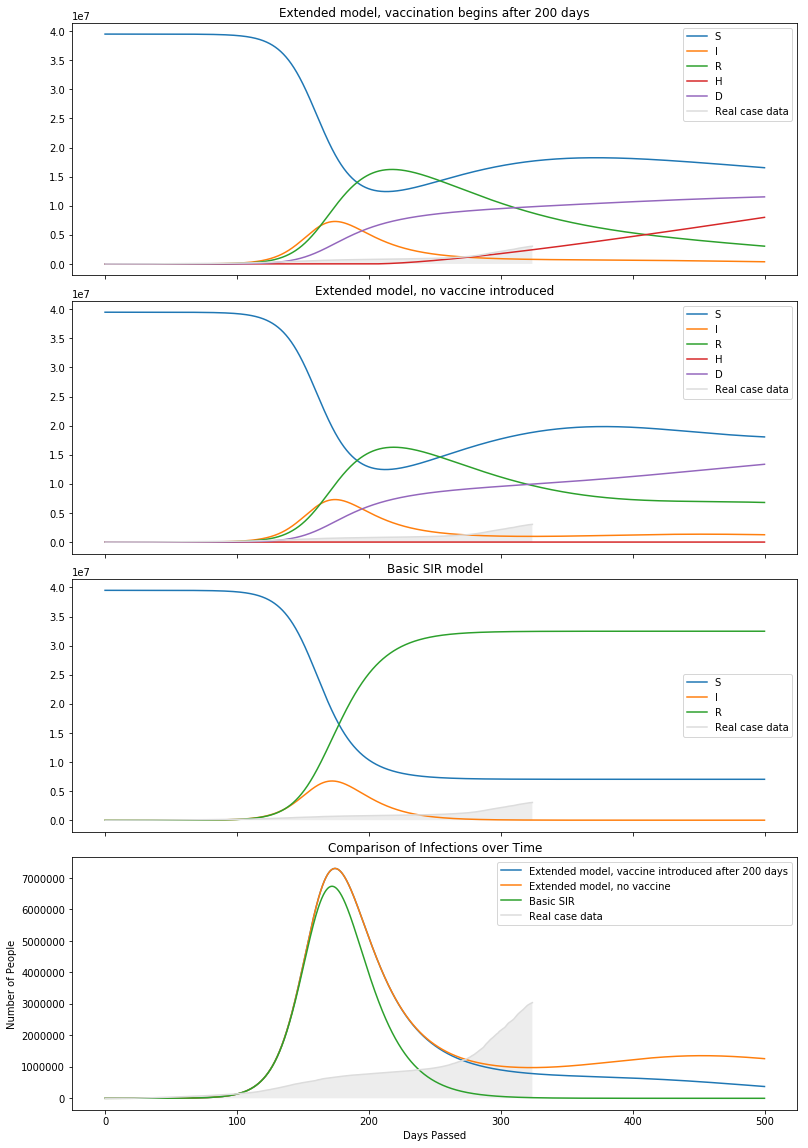



- looked at how the infection curves changed for extended model with varied vaccination rate, vaccination capacity, and lag. 
- compared infection rates for different k values with I0 = 53, N = 3.95*10**6,  k = 0.5*g, g , 1.5*g, 0.15, 2.5*g, 3*g, g = 1/14, v = 0.01*N, r = 50, duration = 500 , lag = 80, A = 0, d = 0.016, dt = 0.0, w = 90

From this it is clear that if the HIT point is reached before the cases spike, the pandemic severity is greatly dampened. 

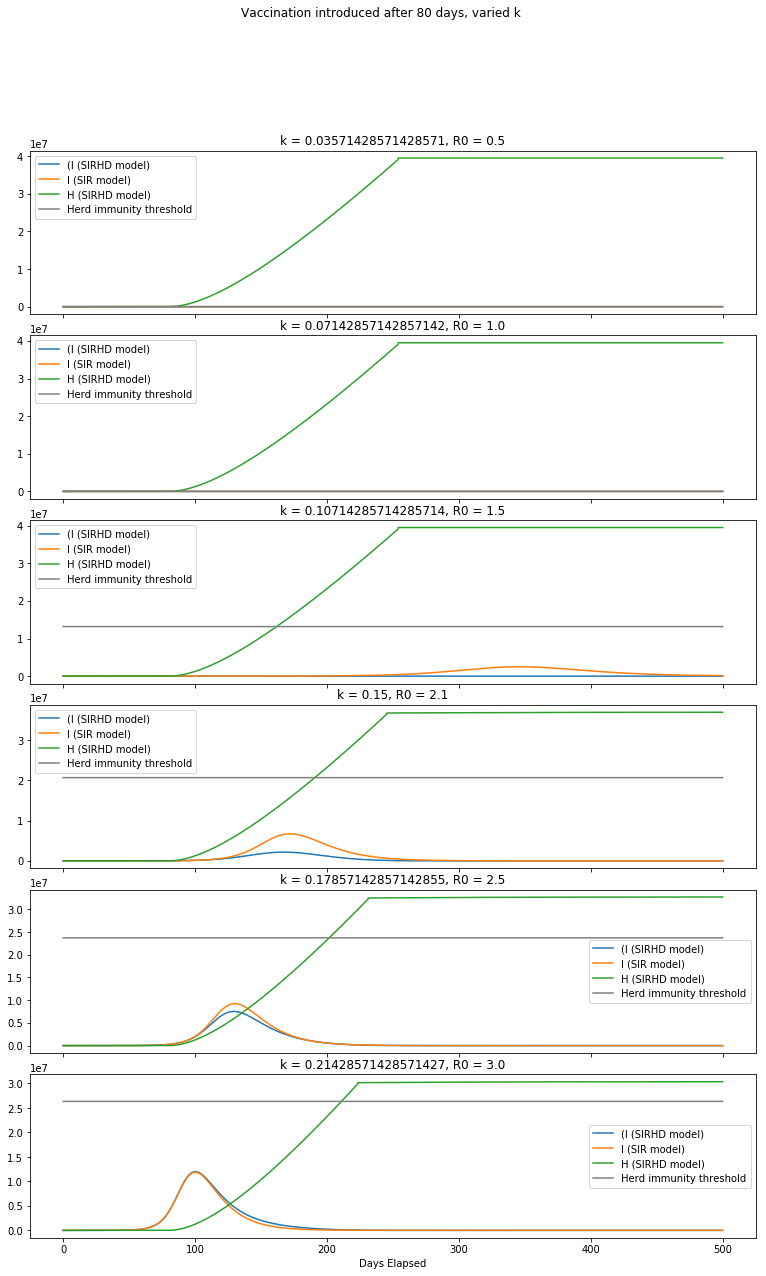

Also added HIT point: $HIT = 1-\frac{1}{R_0}$, $R_0 = \frac{k}{g}. [source](https://www.journalofinfection.com/article/S0163-4453(20)30154-7/fulltext)
